# Map Analysis III

### Jeff McMahon and Renée Hložek 

# CMB Polarization

In this section we generalize our code to handle polarization.  This means creating T, E, and B maps following the same general procedure we used for generating the T maps (but with a corelation between T and E).  We then transform these maps into Q and U maps.  These calculations are carried out in the flat sky approximation, but the treatment in a curved sky is analogous. 

After simulating these maps we present the problems associated with a cut sky and the associated E-B mode mixing.  We then present Kendrick Smith's no-leak pseudo-$C_\ell$ estimator as one of the possible solutions to this mixing problem

## Incorporating previous bits of code

In [131]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

%matplotlib inline
import constants as cs # the constants module

from cmb_modules import * # the module of functions

### paramaters to set up the Poisson point source distribution
Number_of_Sources  = 5000.
Amplitude_of_Sources = 200.
Number_of_Sources_EX = 50.
Amplitude_of_Sources_EX = 1000.

def Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources):
    "makes a realization of a naive Poisson-distributed point source map"
    "takes in the number of pixels, the size of the pixels and the number and amplitude of the sources"
    PSMap = np.zeros([int(N),int(N)])
    i = 0.
    # we throw random numbers repeatedly with amplitudes given by a Poisson distribution around the mean amplitude
    while (i < Number_of_Sources):
        pix_x = int(N*np.random.rand())
        pix_y = int(N*np.random.rand()) 
        PSMap[pix_x,pix_y] += np.random.poisson(Amplitude_of_Sources)
        i = i + 1

    return(PSMap)    
  ############################### 

def Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX):
    "makes a realization of a naive exponentially-distributed point source map"
    PSMap = np.zeros([int(N),int(N)])
    i = 0.
    # we throw random numbers repeatedly with amplitudes given by an exponential distribution around the mean amplitude
    while (i < Number_of_Sources_EX):
        pix_x = int(N*np.random.rand()) 
        pix_y = int(N*np.random.rand()) 
        
        PSMap[pix_x,pix_y] += np.random.exponential(Amplitude_of_Sources_EX)
        i = i + 1

    return(PSMap)    
  ###############################
    
## make a point source map

PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)

### paramaters to set up the SZ point sources
Number_of_SZ_Clusters  = 500
Mean_Amplitude_of_SZ_Clusters = 50
SZ_beta = 0.86
SZ_Theta_core = 1.0

def SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,do_plots):
    "makes a realization of a naive SZ map"
    N=int(N)
    SZMap = np.zeros([N,N])
    SZcat = np.zeros([3,Number_of_SZ_Clusters]) ## catalogue of SZ sources, X, Y, amplitude
    # make a distribution of point sources with varying amplitude
    i = 0
    while (i < Number_of_SZ_Clusters):
        pix_x = int(N*np.random.rand())
        pix_y = int(N*np.random.rand())
        pix_amplitude = np.random.exponential(Mean_Amplitude_of_SZ_Clusters)*(-1.)
        SZcat[0,i] = pix_x
        SZcat[1,i] = pix_y
        SZcat[2,i] = pix_amplitude
        SZMap[pix_x,pix_y] += pix_amplitude
        i = i + 1
    if (do_plots):
        hist,bin_edges = np.histogram(SZMap,bins = 50,range=[SZMap.min(),-10])
        plt.figure(figsize=(10,10))
        plt.semilogy(bin_edges[0:-1],hist)
        plt.xlabel('source amplitude [$\mu$K]')
        plt.ylabel('number of pixels')
        plt.show()
    
    # make a beta function
    beta = beta_function(int(N),pix_size,SZ_beta,SZ_Theta_core)
    
    # convolve the beta function with the point source amplitude to get the SZ map
    # NOTE: you should go back to the Intro workshop for more practice with convolutions!
    FT_beta = np.fft.fft2(np.fft.fftshift(beta))
    FT_SZMap = np.fft.fft2(np.fft.fftshift(SZMap))
    SZMap = np.fft.fftshift(np.real(np.fft.ifft2(FT_beta*FT_SZMap)))
    
    # return the SZ map
    return(SZMap,SZcat)    
  ############################### 

def beta_function(N,pix_size,SZ_beta,SZ_Theta_core):
  # make a beta function

    N=int(N)
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) * pix_size
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    # compute the same real-space R function as before for the PS
    R = np.sqrt(X**2. + Y**2.)
    
    beta = (1 + (R/SZ_Theta_core)**2.)**((1-3.*SZ_beta)/2.)

    # return the beta function map
    return(beta)
  ############################### 
    
## make a point source map

SZMap,SZCat = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)

beam_size_fwhp = 1.25

def convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,Map):
    "convolves a map with a Gaussian beam pattern.  NOTE: pix_size and beam_size_fwhp need to be in the same units" 
    # make a 2d gaussian 
    gaussian = make_2d_gaussian_beam(N,pix_size,beam_size_fwhp)
  
    # do the convolution
    FT_gaussian = np.fft.fft2(np.fft.fftshift(gaussian)) # first add the shift so that it is central
    FT_Map = np.fft.fft2(np.fft.fftshift(Map)) #shift the map too
    convolved_map = np.fft.fftshift(np.real(np.fft.ifft2(FT_gaussian*FT_Map))) 
    
    # return the convolved map
    return(convolved_map)
  ###############################
    
white_noise_level = 10.
atmospheric_noise_level = 0.1  # multiply by zero to turn this off
one_over_f_noise_level = 0.2 # multiply by zero to turn this off

def make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level):
    "makes a realization of instrument noise, atmosphere and 1/f noise level set at 1 degrees"
    ## make a white noise map
    white_noise = np.random.normal(0,1,(N,N)) * white_noise_level/pix_size
 
    ## make an atnosperhic noise map
    atmospheric_noise = 0.
    if (atmospheric_noise_level != 0):
        ones = np.ones(N)
        inds  = (np.arange(N)+.5 - N/2.) 
        X = np.outer(ones,inds)
        Y = np.transpose(X)
        R = np.sqrt(X**2. + Y**2.) * pix_size /60. ## angles relative to 1 degrees  
        mag_k = 2 * np.pi/(R+.01)  ## 0.01 is a regularization factor
        atmospheric_noise = np.fft.fft2(np.random.normal(0,1,(N,N)))
        atmospheric_noise  = np.fft.ifft2(atmospheric_noise * np.fft.fftshift(mag_k**(5/3.)))
        atmospheric_noise = atmospheric_noise * atmospheric_noise_level/pix_size

    ## make a 1/f map, along a single direction to illustrate striping 
    oneoverf_noise = 0.
    if (one_over_f_noise_level != 0): 
        ones = np.ones(N)
        inds  = (np.arange(N)+.5 - N/2.) 
        X = np.outer(ones,inds) * pix_size /60. ## angles relative to 1 degrees 
        kx = 2 * np.pi/(X+.01) ## 0.01 is a regularization factor
        oneoverf_noise = np.fft.fft2(np.random.normal(0,1,(N,N)))
        oneoverf_noise = np.fft.ifft2(oneoverf_noise * np.fft.fftshift(kx))* one_over_f_noise_level/pix_size

    ## return the noise map
    noise_map = np.real(white_noise + atmospheric_noise + oneoverf_noise)
    return(noise_map)
  ###############################

## make an instrument noise map
Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)

We also read in the constants for map noise, beam shape, and point sources so we can use these in the excercises

In [133]:
N = cs.N
N_iterations = cs.N_iterations
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp

pix_size = cs.pix_size

Number_of_Sources  = cs.Number_of_Sources
Amplitude_of_Sources = cs.Amplitude_of_Sources
Number_of_Sources_EX = cs.Number_of_Sources_EX
Amplitude_of_Sources_EX = cs.Amplitude_of_Sources_EX

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

white_noise_level = cs.white_noise_level
atmospheric_noise_level = 0 #cs.atmospheric_noise_level
one_over_f_noise_level = 0 #cs.one_over_f_noise_level

## we will need a window function below, so we create it here
window = (cosine_window(N))

delta_ell=cs.delta_ell
ell_max=cs.ell_max

## Read in and plot the TT, EE, BB, and TE power spectra

With polarization there are four cosmologial power spectra to work with.   As you can see here, the main challenge is handling four times the book keeping.

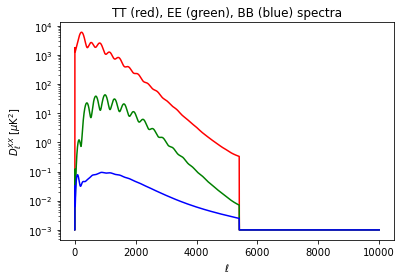

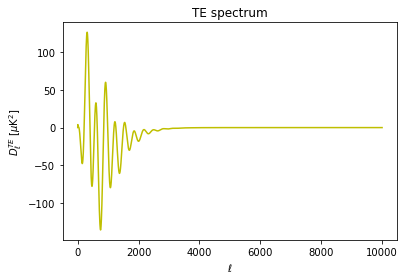

In [59]:
nbig = 10000
# read in the input CMB spectra
ell, DlTT,DlEE,DlBB, DlTE= np.loadtxt("CMB_fiducial_totalCls.dat", usecols=(0, 1,2,3,4), unpack=True) 

##
ell_big = np.arange(nbig)
DlTT_big = np.zeros(nbig)
DlTT_big[ell.astype(int)] = DlTT
DlEE_big = np.zeros(nbig)
DlEE_big[ell.astype(int)] = DlEE
DlBB_big = np.zeros(nbig)
DlBB_big[ell.astype(int)] = DlBB
DlTE_big = np.zeros(nbig)
DlTE_big[ell.astype(int)] = DlTE

ell = ell_big
DlTT = DlTT_big + 1e-3   ### the 1e-3 factor maps plotting easy
DlEE = DlEE_big + 1e-3
DlBB = DlBB_big + 1e-3
DlTE = DlTE_big

Temp_point_source_spectrum = DlTT[3000]*(ell/3000.)**2.
Pol_point_source_spectrum = DlEE[4500]*(ell/4500.)**2.

DlTT_PS = DlTT + Temp_point_source_spectrum   ### these are used for computing the transer functions
DlEE_PS = DlEE + Pol_point_source_spectrum
DlBB_PS = DlBB + Pol_point_source_spectrum


plt.semilogy(ell,DlTT,'r')
plt.semilogy(ell,DlEE,'g')
plt.semilogy(ell,DlBB,'b')
plt.title('TT (red), EE (green), BB (blue) spectra')
plt.ylabel('$D^{XX}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

plt.plot(ell,DlTE,'y')
plt.ylabel('$D^{TE}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('TE spectrum')
plt.show()

These spectra probably look familiar to you.   If you wish to explore the cosmological dependence of these spectra, you can simulate these spectra using CAMB on the NASA Lambda website just as we did in Part two of this course.  A key apsect for simmulation and analysis is that the information in the TT, EE, and BB are entirely contained in the T, E, and B maps, respectively;  while the TE information is contained within the T and E maps through a paritial correlation that comes about from how the T and E fluctuations are sourced in the early universe.  We will have to build in this correlation when we simulate the triplet of T, E, and B maps

## Simulate T, E, and B maps

Here we introduce a function to create T, Q, and U maps.   To do this we follow the same procedure for creating T, E and B maps that we introduced in Part two of this course with the exception of introducing a T-E correlation.  We then transform into Q and U maps.

The correlation is introduced by (1) generating Gaussian random fields for the T, B, and uncorrelated part of the E maps; (2) separating the E-mode spectrum into a piece that is correlated with T: 
$$C_\ell^{EE, correlated} = r^2_\ell C_\ell^{EE} $$ 
where $$r_\ell = \frac {(C_\ell^{TE})} {\sqrt{C_\ell^{EE}C_\ell^{TT}}},$$ and a part that has represents the amplitude of the uncorrelated fluctuations (chosen such that the correlated and uncorelated E- fluctuations reproduce the EE spectrum: $$C_\ell^{uncorrelated} = (1-r^2_\ell) C_\ell^{EE};$$ and then generating the E- map as a sum of realizations of these two pieces.



The relation between E-B and Q-U maps is given by a position dependent rotation in fourier space.  We introduce an angle $\psi= \arctan \frac {k_Y} {k_X}$, where $k_X$ and $k_Y$ are the wave numbers in fourier space.   With this angle in had the relation between E-B and Q-U is:
$$\tilde Q  = \tilde E \cos 2 \psi - \tilde B \sin 2 \psi$$
$$\tilde U  = \tilde E \sin 2 \psi + \tilde B \cos 2 \psi$$

The ~ over the Q, U, E, and B are to remind you that these quantities are in Fourier space.  

As this is a simple rotation, the inverse transfom is:
$$\tilde E  = \tilde Q \cos 2 \psi + \tilde U \sin 2 \psi$$
$$\tilde B  = -\tilde Q \sin 2 \psi + \tilde U \cos 2 \psi$$

map mean: 3.372302437298913e-15 map rms: 95.56117143978263


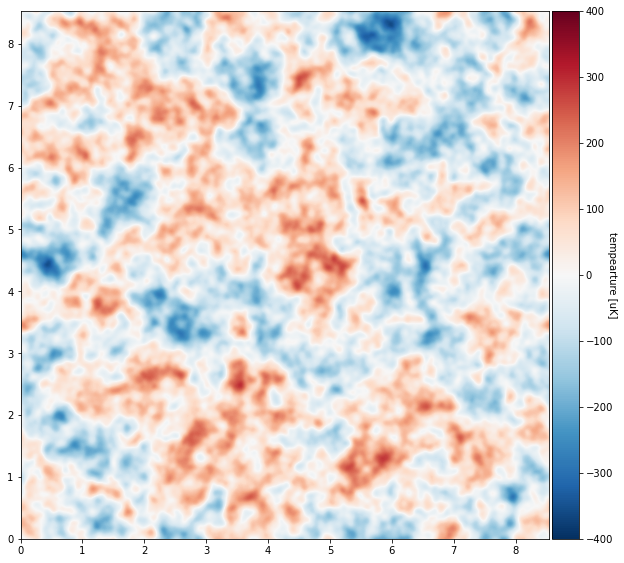

map mean: -2.0816681711721685e-17 map rms: 4.638779418509742


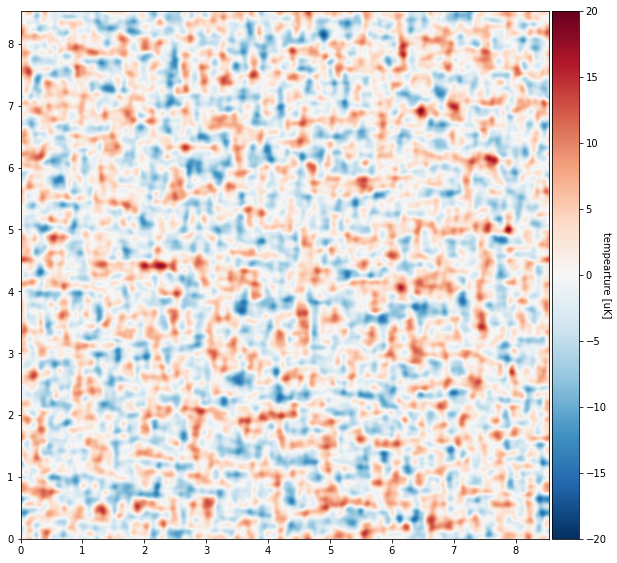

map mean: 1.734723475976807e-18 map rms: 4.732196200664853


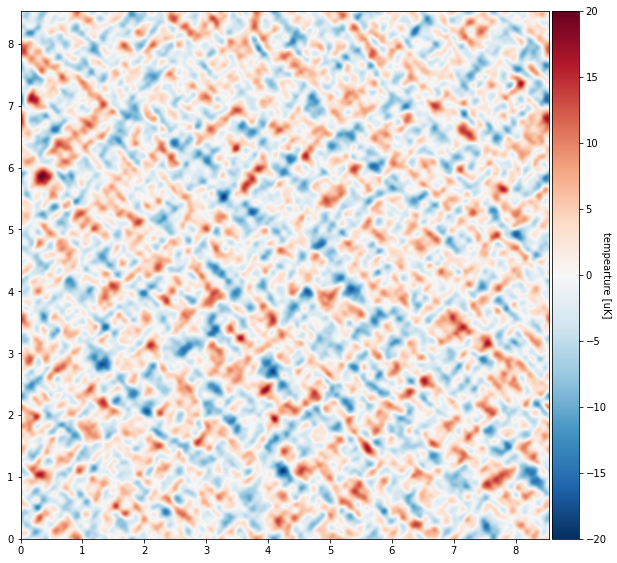

map mean: 1.734723475976807e-18 map rms: 6.606150974510621


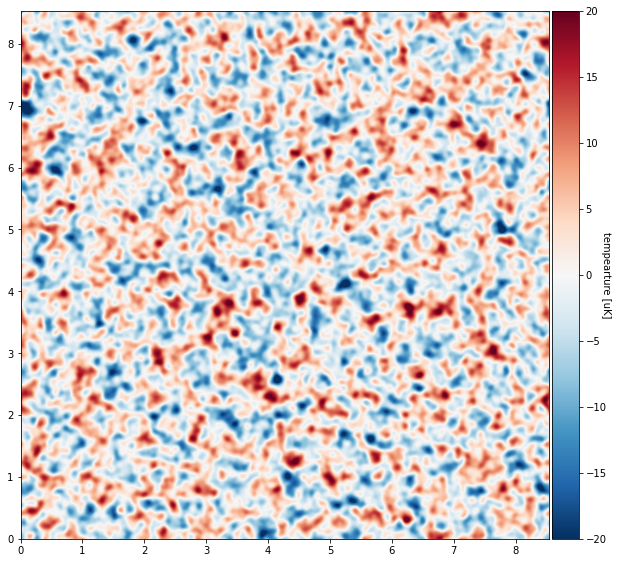

map mean: 3.144186300207963e-17 map rms: 0.5203120959086284


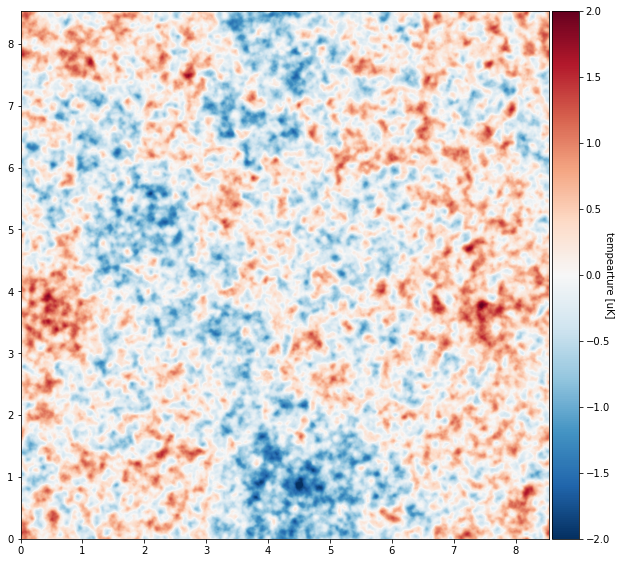

In [60]:
def make_CMB_maps(N,pix_size,ell,DlTT,DlEE,DlTE,DlBB):
    "makes a realization of a simulated CMB sky map"

    # convert Dl to Cl, we use np.divide to avoid dividing by zero.
    dell = ell * (ell + 1) / 2 / np.pi
    ClTT = np.divide(DlTT, dell, where=ell>1)
    ClEE = np.divide(DlEE, dell, where=ell>1)
    ClTE = np.divide(DlTE, dell, where=ell>1)
    ClBB = np.divide(DlBB, dell, where=ell>1)
    
    # set the \ell = 0 and \ell =1 modes to zero as these are unmeasurmable and blow up with the above transform
    ClTT[0:2] = 0.
    ClEE[0:2] = 0.
    ClTE[0:2] = 0.
    ClBB[0:2] = 0.

    # separate the correlated and uncorrelated part of the EE spectrum
    correlated_part_of_E = np.divide(ClTE, np.sqrt(ClTT), where=ell>1)
    uncorrelated_part_of_EE = ClEE - np.divide(ClTE**2., ClTT, where=ell>1)
    
    correlated_part_of_E[0:2] = 0.
    uncorrelated_part_of_EE[0:2] = 0.
    
    # make a 2d coordinate system
    ones = np.ones(N)
    inds  = (np.arange(N) - N/2.) /(N-1.)
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2.)
    ang = np.arctan2(Y,X)   ## we now need this angle to handle the EB <--> QU rotation
    
    # now make a set of 2d CMB masks for the T, E, and B maps
    ell_scale_factor = 2. * np.pi / (pix_size/60. * np.pi/180.)
    ell2d = R * ell_scale_factor
    ClTT_expanded = np.zeros(int(ell2d.max())+1)
    ClTT_expanded[0:(ClTT.size)] = ClTT
    ClEE_uncor_expanded = np.zeros(int(ell2d.max())+1)
    ClEE_uncor_expanded[0:(uncorrelated_part_of_EE.size)] = uncorrelated_part_of_EE
    ClE_corr_expanded = np.zeros(int(ell2d.max())+1)
    ClE_corr_expanded[0:(correlated_part_of_E.size)] = correlated_part_of_E
    ClBB_expanded = np.zeros(int(ell2d.max())+1)
    ClBB_expanded[0:(ClBB.size)] = ClBB
    CLTT2d = ClTT_expanded[ell2d.astype(int)]
    ClEE_uncor_2d = ClEE_uncor_expanded[ell2d.astype(int)]
    ClE_corr2d = ClE_corr_expanded[ell2d.astype(int)]
    CLBB2d = ClBB_expanded[ell2d.astype(int)]
    
    # now make a set of gaussian random fields that will be turned into the CMB maps
    randomn_array_for_T = np.fft.fft2(np.random.normal(0,1,(N,N)))
    randomn_array_for_E = np.fft.fft2(np.random.normal(0,1,(N,N))) 
    randomn_array_for_B = np.fft.fft2(np.random.normal(0,1,(N,N))) 
    
    ## make the T, E, and B maps by multiplying the masks against the random fields
    FT_2d = np.sqrt(CLTT2d) * randomn_array_for_T
    FE_2d = np.sqrt(ClEE_uncor_2d) * randomn_array_for_E + ClE_corr2d* randomn_array_for_T
    FB_2d = np.sqrt(CLBB2d) * randomn_array_for_B
    
    ## now conver E abd B to Q and U
    FQ_2d = FE_2d* np.cos(2.*ang) - FB_2d * np.sin(2. *ang)
    FU_2d = FE_2d* np.sin(2.*ang) + FB_2d * np.cos(2. *ang)
    
    ## convert from fourier space to real space
    CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) /(pix_size /60.* np.pi/180.)
    CMB_T = np.real(CMB_T)
    CMB_Q = np.fft.ifft2(np.fft.fftshift(FQ_2d)) /(pix_size /60.* np.pi/180.)
    CMB_Q = np.real(CMB_Q)
    CMB_U = np.fft.ifft2(np.fft.fftshift(FU_2d)) /(pix_size /60.* np.pi/180.)
    CMB_U = np.real(CMB_U)

    ## optional code for spitting out E and B maps 
    CMB_E = np.fft.ifft2(np.fft.fftshift(FE_2d)) /(pix_size /60.* np.pi/180.)
    CMB_E = np.real(CMB_E)
    CMB_B = np.fft.ifft2(np.fft.fftshift(FB_2d)) /(pix_size /60.* np.pi/180.)
    CMB_B = np.real(CMB_B)
    
    ## return the maps
    return(CMB_T,CMB_Q,CMB_U,CMB_E,CMB_B)
  ###############################


    
## make a CMB T map
CMB_T,CMB_Q,CMB_U,CMB_E,CMB_B = make_CMB_maps(N,pix_size,ell,DlTT,DlEE,DlTE,DlBB)


p = Plot_CMB_Map(CMB_T,c_min,c_max,X_width,Y_width)
p = Plot_CMB_Map(CMB_Q,c_min/20.,c_max/20.,X_width,Y_width)
p = Plot_CMB_Map(CMB_U,c_min/20.,c_max/20.,X_width,Y_width)
p = Plot_CMB_Map(CMB_E,c_min/20.,c_max/20.,X_width,Y_width)
p = Plot_CMB_Map(CMB_B,c_min/200.,c_max/200.,X_width,Y_width)

Note the RMS of these maps: the T is ~100 $\mu$K, the Q and U are ~ 4.5 $\mu$K, the E is ~ 6.5 $\mu$K, and the B map rms is $<1 \mu K$.  Knowing these values is a good useful starting point for debuging simulations, calibration of real maps, and tracking the impact of filtering on maps.

<font color='red'>EXCERCISE: </font>  Add point sources and the SZ to these maps, next convolve with a beam, and add instrumental noise.   Assume the point sources have a fixed $3\%$ polarization fraction with random polarization angles and the SZ is fully unpolarized.  The noise in the polarization maps is $\sqrt 2$ larger than the temperature noise.

In [110]:
# Generate random polarization angle map
random_angle = np.random.uniform(low=0, high=180, size=CMB_Q.shape)

# Calculate polarization vector magnitude
polarization_magnitude = np.sqrt(CMB_Q**2 + CMB_U**2) * 0.03

# Calculate polarization vector in Q-U plane
polarization_Q = polarization_magnitude * np.cos(2 * np.radians(random_angle))
polarization_U = polarization_magnitude * np.sin(2 * np.radians(random_angle))

# Add polarization vector to CMB_Q and CMB_U maps
CMB_Q = CMB_Q + polarization_Q
CMB_U_polarized = CMB_U + polarization_U

map mean: -13.043565359139645 map rms: 97.01314737365487


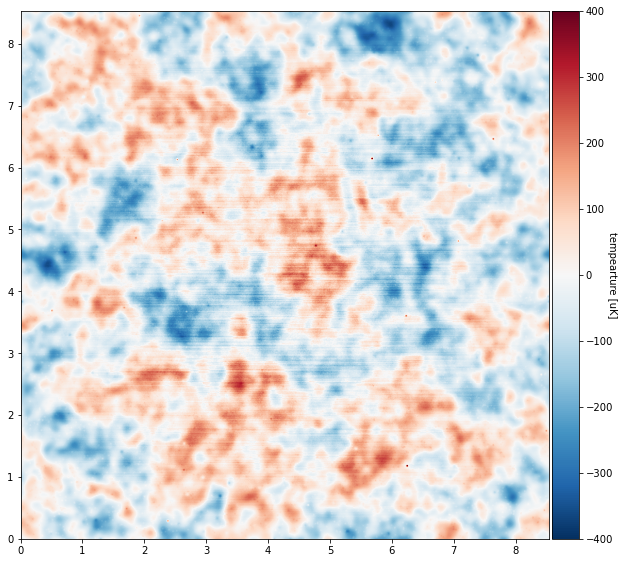

map mean: -16.126488483073985 map rms: 106.70336937610811


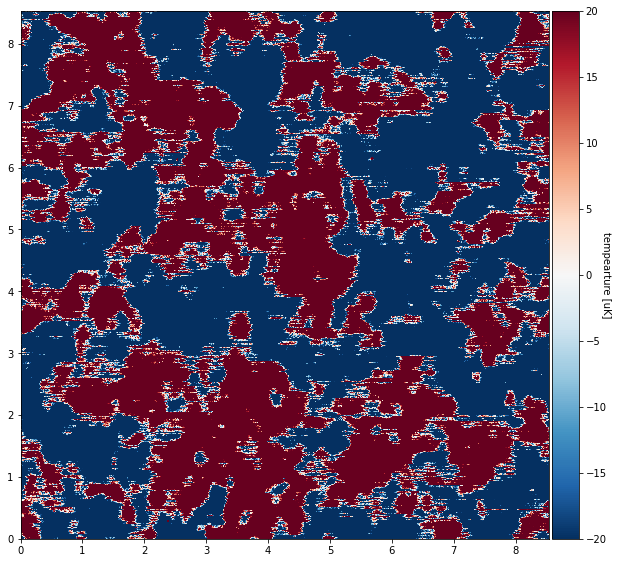

map mean: -16.126488483073985 map rms: 106.70336937610811


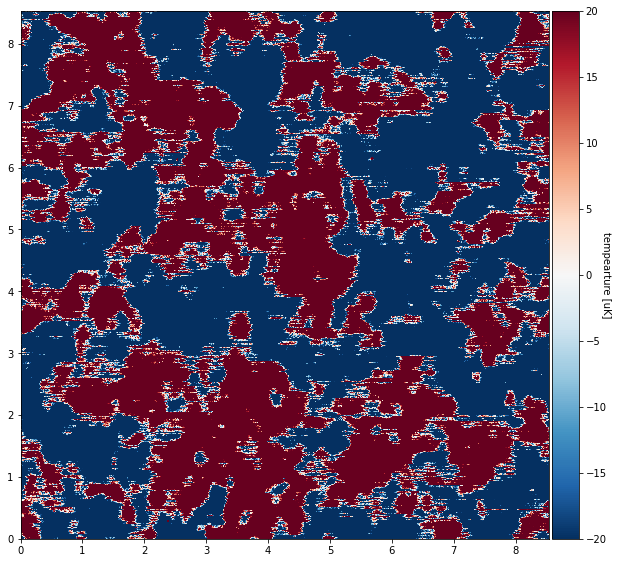

map mean: -14.6701804355547 map rms: 101.13302584970428


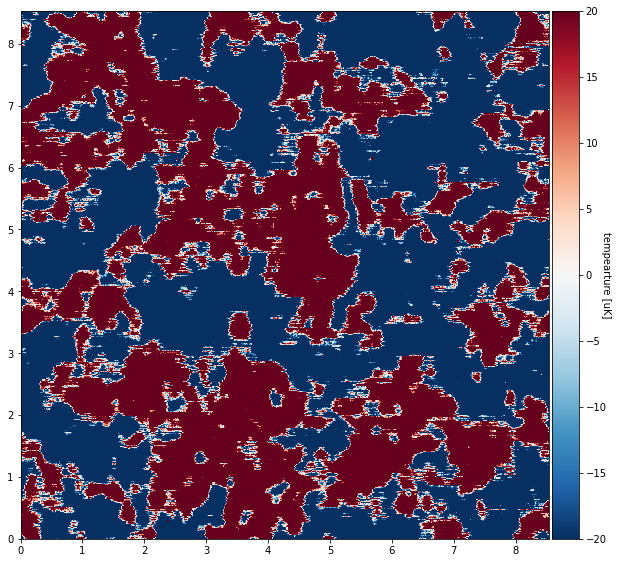

map mean: -14.6701804355547 map rms: 101.13302584970428


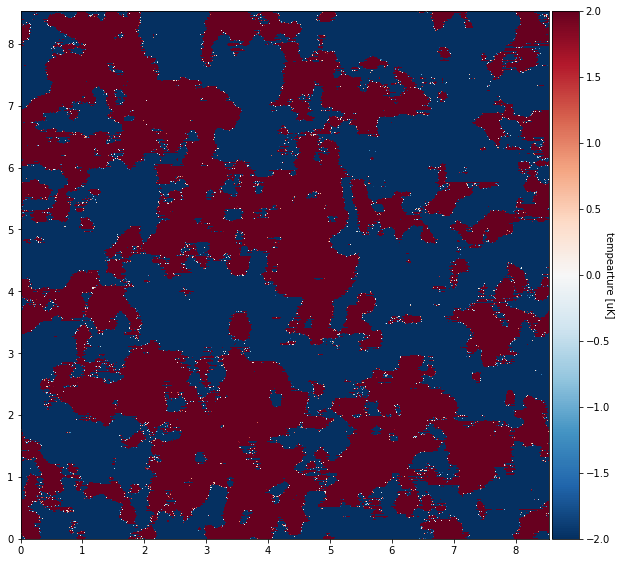

In [156]:
total_map_T=CMB_T+PSMap+SZMap
total_map_Q=CMB_Q+PSMap+SZMap
total_map_U=CMB_U+PSMap+SZMap
total_map_E=CMB_E+PSMap+SZMap
total_map_B=CMB_B+PSMap+SZMap
CMB_T_convolved = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map_T)
CMB_Q_convolved = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map_Q)
CMB_U_convolved = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map_U)
CMB_E_convolved = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map_E)
CMB_B_convolved = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map_B)
TotalMapT=CMB_T_convolved+Noise*window
TotalMapQ=CMB_T_convolved+(np.sqrt(2)*Noise)
TotalMapU=CMB_T_convolved+(np.sqrt(2)*Noise)
TotalMapE=CMB_T_convolved+Noise
TotalMapB=CMB_T_convolved+Noise
p = Plot_CMB_Map(TotalMapT,c_min,c_max,X_width,Y_width)
p = Plot_CMB_Map(TotalMapQ,c_min/20.,c_max/20.,X_width,Y_width)
p = Plot_CMB_Map(TotalMapU,c_min/20.,c_max/20.,X_width,Y_width)
p = Plot_CMB_Map(TotalMapE,c_min/20.,c_max/20.,X_width,Y_width)
p = Plot_CMB_Map(TotalMapB,c_min/200.,c_max/200.,X_width,Y_width)

## Directly visualize the polarization field

In the above we have visualized the polarization field using two different methods: a decomposition into Stokes Q and U maps, and a decomposition into E- and B-modes. Sometimes it is useful to instead visualize the polarization field as a vector field of (headless) vectors that directly show the orientation and amplitude of the (linearly) polarized light.

Below we generate a plot like this using vectors of length $p = \sqrt{Q^2 + U^2}$ and orientation $\psi_p$ given by $2 \psi_p = \arctan\left( \frac{U}{Q}\right)$. We overlay this plot over the E mode map to demonstrate that the polarization field (which is dominated by E-modes) closely traces this map.

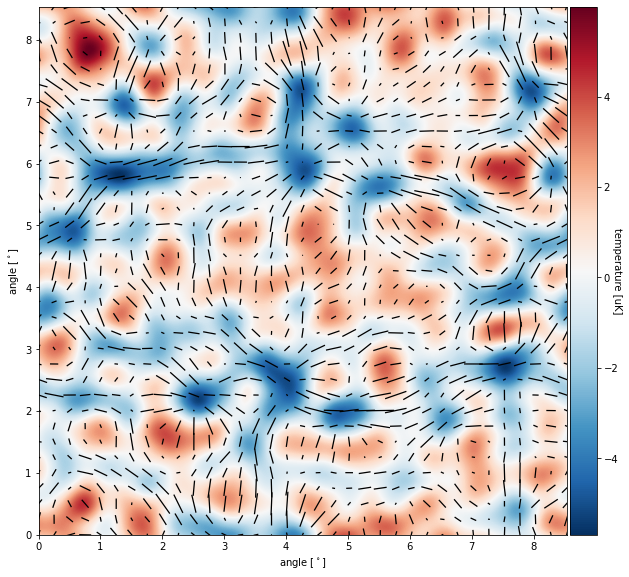

In [38]:
def plot_quiver(Q, U, X_width, Y_width, background=None):
    '''Visualize Stokes Q, U as headless vectors'''
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    # Smooth maps for nicer images
    fwhm_pix = 30
    Q = convolve_map_with_gaussian_beam(N,pix_size,fwhm_pix,Q)
    U = convolve_map_with_gaussian_beam(N,pix_size,fwhm_pix,U)
    if background is not None:
        # If provided, we overplot the vectors on top of the smoothed background.
        background = convolve_map_with_gaussian_beam(N,pix_size,fwhm_pix,background)
    
    Q = Q[::int(fwhm_pix),::int(fwhm_pix)]
    U = U[::int(fwhm_pix),::int(fwhm_pix)]
    
    p_amp = np.sqrt(Q**2 + U**2)
    ang = np.arctan2(U, Q) / 2.
    
    u = p_amp * np.cos(ang)
    v = p_amp * np.sin(ang)

    x = np.linspace(0,X_width,u.shape[1])
    y = np.linspace(0,X_width,u.shape[0])    
        
    fig, ax = plt.subplots(figsize=(10,10))
    if background is not None:
        im = ax.imshow(background, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r,
                       extent=([0,X_width,0,Y_width]))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label('temperature [uK]', rotation=270)
        
    ax.quiver(x, y, u, v, headwidth=1, headlength=0, pivot='mid', units='xy',
              scale_units='xy', scale=2 * p_amp.max(), linewidth=1)
        
    ax.set_ylabel('angle $[^\circ]$')
    ax.set_xlabel('angle $[^\circ]$')
    
    plt.show(fig)

plot_quiver(CMB_Q,CMB_U,X_width,Y_width,background=CMB_E)

<font color='red'>EXCERCISE: </font>  Generate a polarization field dominated by B-mode polarization and plot the polarization vectors on top of the B-mode map. What is the difference between the E-mode field and the B-mode field?

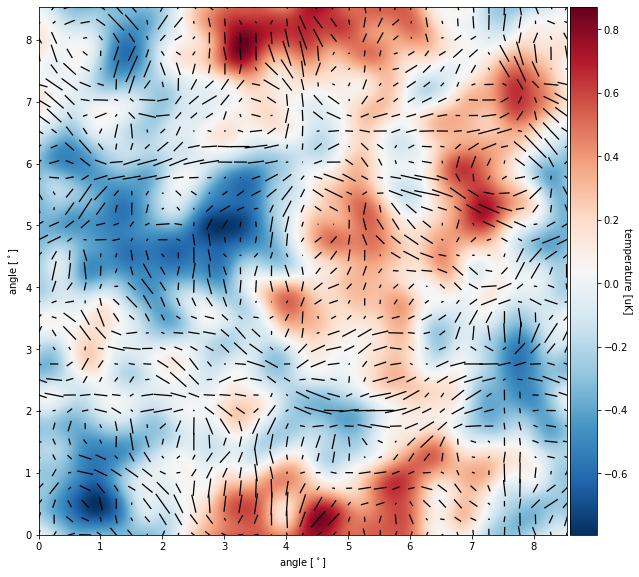

In [39]:
plot_quiver(CMB_Q,CMB_U,X_width,Y_width,background=CMB_B)

<font color='red'>EXCERCISE: </font>  Calculate the BB power spectrum using the code and Monte Carlo techniques we explored in Part Four.  Compare your results to the input spectra. Make sure to include a window (i.e. pixel mask).  


<font color='red'>hint: </font> You can make use of the `QU2EB()` function below to convert Q and U maps to E and B maps. Because real data would be provided as Q and U maps, a pixel mask should be applied to the Q and U maps before converting to E and B.

In [157]:
binned_ell, binned_spectrum = calculate_2d_spectrum(TotalMapT,delta_ell,ell_max,pix_size,N)

 noise only sims, iterations complete: 16 of 16

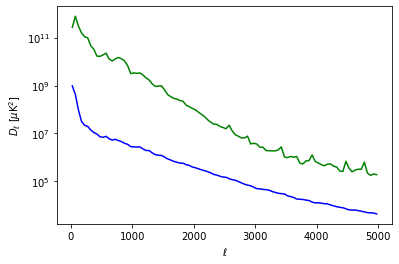

In [161]:
def QU2EB(N,pix_size,Qmap,Umap,):
    '''Calcalute E, B maps given input Stokes Q, U maps'''
    
    # Create 2d Fourier coordinate system.
    ones = np.ones(N)
    inds  = (np.arange(N) - N/2.) /(N-1.)
    kX = np.outer(ones,inds) / (pix_size/60. * np.pi/180.)
    kY = np.transpose(kX)
    ang = np.arctan2(kY,kX)
  
    # Convert to Fourier domain.
    fQ = np.fft.fftshift(np.fft.fft2(Qmap))
    fU = np.fft.fftshift(np.fft.fft2(Umap))
    
    # Convert Q, U to E, B in Fourier domain.
    fE = fQ * np.cos(2.*ang) + fU * np.sin(2. *ang)
    fB = - fQ * np.sin(2.*ang) + fU * np.cos(2. *ang)
    
    # Convert E, B from Fourier to real space.
    Emap = np.real(np.fft.ifft2(np.fft.fftshift(fE)))
    Bmap = np.real(np.fft.ifft2(np.fft.fftshift(fB)))

    return Emap, Bmap

# Convert masked Q, U to E and B.
Emap, Bmap = QU2EB(N,pix_size,CMB_Q * window,CMB_U * window)

#Plot_CMB_Map(window,0,1,X_width,Y_width)
#Plot_CMB_Map(Emap,-20,20,X_width,Y_width)
#Plot_CMB_Map(Bmap,-2,2,X_width,Y_width)

def generate_random_angles(N):
    return np.random.uniform(0, 2*np.pi, (N, N))

polarization_fraction = 0.03  # Polarization fraction (3%)
mask = window

# Apply mask to Q and U maps
Qmap_masked = CMB_Q * mask
Umap_masked = CMB_U * mask

# Convert masked Q and U maps to E and B maps
Emap, Bmap = QU2EB(N, pix_size, Qmap_masked, Umap_masked)

# Generate random polarization angles
angles = generate_random_angles(N)

# Apply polarization fraction to Bmap
Bmap_polarized = polarization_fraction * Bmap * np.cos(2 * angles)

# Perform Fourier transform of polarized Bmap
fB_polarized = np.fft.fftshift(np.fft.fft2(Bmap_polarized))

signal_only  = np.zeros([N_iterations,int(ell_max/delta_ell)])
i = 0
while (i <N_iterations):
    random_phases = np.exp(2j * np.pi * np.random.uniform(0, 1, (N, N)))
    fB_realization = fB_polarized * random_phases
    B_realization = np.real(np.fft.ifft2(np.fft.fftshift(fB_realization)))
    binned_ell_cur, binned_spectrum_cur = calculate_2d_spectrum(
        B_realization * window, delta_ell, ell_max, pix_size, N)
    signal_only[i, :] = binned_spectrum_cur
    sys.stdout.write("\rSignal-only sims, iterations complete: %d of %d" % ((i+1), N_iterations))
    sys.stdout.flush()
    i = i + 1

def average_N_spectra(spectra,N_spectra,N_ells):
    avgSpectra = np.zeros(N_ells)
    rmsSpectra = np.zeros(N_ells)
    
    # calcuate the average spectrum
    i = 0
    while (i < N_spectra):
        avgSpectra = avgSpectra + spectra[i,:]
        i = i + 1
    avgSpectra = avgSpectra/(1. * N_spectra)
    
    #calculate the rms of the spectrum
    i =0
    while (i < N_spectra):
        rmsSpectra = rmsSpectra +  (spectra[i,:] - avgSpectra)**2
        i = i + 1
    rmsSpectra = np.sqrt(rmsSpectra/(1. * N_spectra))
    
    return(avgSpectra,rmsSpectra)
noise_only  = np.zeros([N_iterations,int(ell_max/delta_ell)])
i = 0
while (i <N_iterations):
    Noise = make_noise_map(N,pix_size,white_noise_level,0,0)
    binned_ell_cur, binned_spectrum_cur = calculate_2d_spectrum(Noise*window,delta_ell,ell_max,pix_size,N)
    noise_only[i,:] = binned_spectrum_cur
    sys.stdout.write("\r noise only sims, iterations complete: %d of %d" % ((i+1),N_iterations) )
    sys.stdout.flush()
    i = i + 1

noise_only_mean_spectrum, rms_not_needed = average_N_spectra(noise_only,N_iterations,int(ell_max/delta_ell))

Additive_Bias_est = noise_only_mean_spectrum

sig_only_mean_spectrum, rms_not_needed = average_N_spectra(signal_only,N_iterations,int(ell_max/delta_ell))
    
sub_sampled_CLs = DlBB[np.array(binned_ell)] * 2. * np.pi / (binned_ell * (binned_ell + 1.))

Multiplicative_Bias_est =  sub_sampled_CLs / sig_only_mean_spectrum
plt.semilogy(binned_ell,(Multiplicative_Bias_est),color='b')
plt.semilogy(binned_ell,(binned_spectrum -noise_only_mean_spectrum)\
             *Multiplicative_Bias_est* binned_ell * (binned_ell+1.)/2. / np.pi,color='g')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

Your notes go here

<font color='red'>EXCERCISE: </font>  Create a simulated map with $C_\ell^{BB} = 0$ Calculate the BB power spectrum of this map using the estimates for the multiplicitive and addative bias you calculated in the previous excercise with non-zero $C_\ell^{BB}$.   Why isn't your result consistent with $C_\ell^{BB} = 0$   

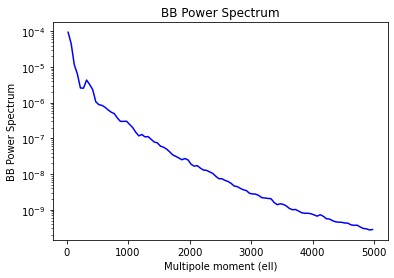

In [114]:
Emap, Bmap = QU2EB(N, pix_size, CMB_Q * window, CMB_U * window)

# Calculate the BB power spectrum using the calculate_2d_spectrum function
ell, power_spectrum = calculate_2d_spectrum(Bmap, 50, 5000, pix_size, N)

# Plot the BB power spectrum
plt.semilogy(ell, power_spectrum, color='b')
plt.xlabel('Multipole moment (ell)')
plt.ylabel('BB Power Spectrum')
plt.title('BB Power Spectrum')
plt.show()

/Users/elaineran/opt/anaconda3/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


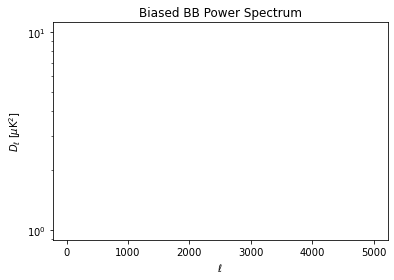

In [169]:
# Create a numpy array to represent ClBB with all zeros
ClBB = np.zeros(1024)

# Generate a random map using the ClBB array
np.random.seed(0)  # Set a random seed for reproducibility
random_map = np.fft.ifft2(np.sqrt(ClBB) * np.exp(1j * np.random.uniform(0, 2*np.pi, (N, N))))

# Calculate the BB power spectrum of the random map
ell_array, spectrum_array = calculate_2d_spectrum(random_map, delta_ell, ell_max, pix_size, N)

# Apply the multiplicative and additive bias estimates
biased_spectrum = (spectrum_array - noise_only_mean_spectrum) * Multiplicative_Bias_est + Additive_Bias_est

# Plot the biased BB power spectrum
plt.semilogy(ell_array, biased_spectrum, color='r')

# Check if the spectrum contains positive values before setting the y-axis scale
if np.any(biased_spectrum > 0):
    plt.yscale('log')

plt.xlabel('$\ell$')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.title('Biased BB Power Spectrum')
plt.show()



your notes go here

<font color='red'>EXCERCISE: </font>  Calculate the TE power spectrum by adapting the techniques from Part Four.

In [10]:
## your code goes here

your notes go here

## Kendrick Smith's no-leak B-mode estimator

Kendrick Smith wrote a nice <a href=https://arxiv.org/abs/astro-ph/0511629>paper</a> describing his solution to the E-B mixing problem on cut skies.  He showed that the leakage is related to the window function used to apodize the maps before moving to fourier space and identified corrections (products of derivitives of the window funciton and the Q and U maps in fourier space) that can be added to create a clean estimate of the B-modes.

We implement his method here so that you can apply it to your simulations and see that it cleans up the B-mode estimate you produced above.

map mean: 3.6028680762499654 map rms: 48.89665052363722


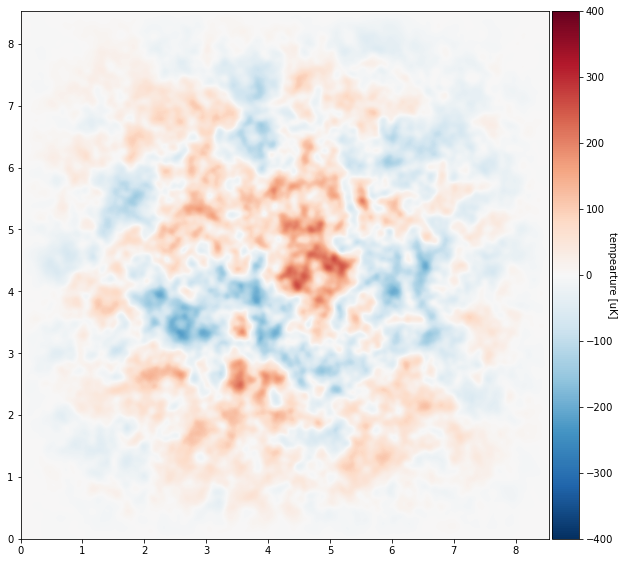

map mean: -0.034790992566419016 map rms: 3.36338106147728


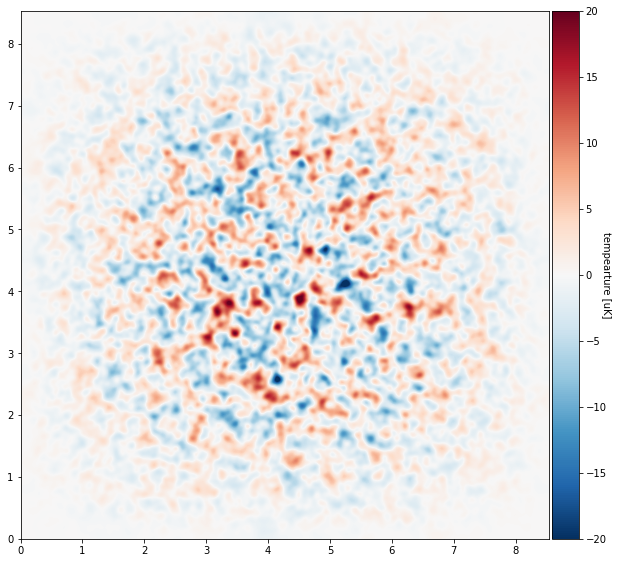

map mean: -3.5475095083725705e-15 map rms: 0.24929916845159045


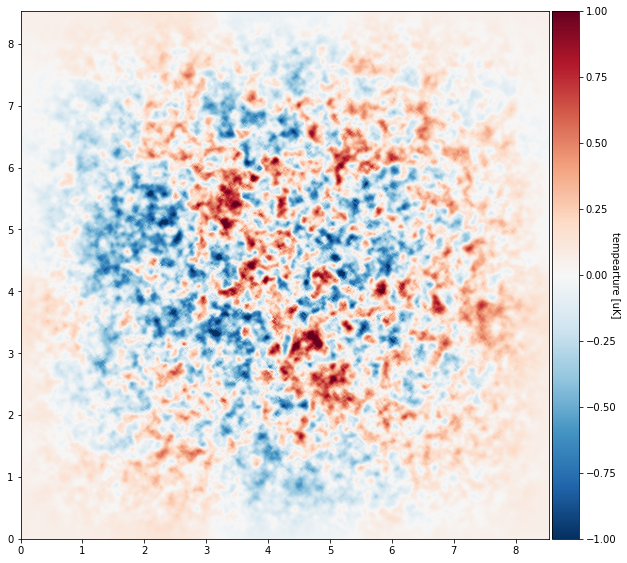

In [171]:
def kendric_method_precompute_window_derivitives(win,pix_size):
    delta = pix_size * np.pi /180. /60.
    dwin_dx =    ((-1.) * np.roll(win,-2,axis =1)      +8. * np.roll(win,-1,axis =1)     - 8. *np.roll(win,1,axis =1)      +np.roll(win,2,axis =1) ) / (12. *delta)
    dwin_dy =    ((-1.) * np.roll(win,-2,axis =0)      +8. * np.roll(win,-1,axis =0)     - 8. *np.roll(win,1,axis =0)      +np.roll(win,2,axis =0) ) / (12. *delta)
    d2win_dx2 =  ((-1.) * np.roll(dwin_dx,-2,axis =1)  +8. * np.roll(dwin_dx,-1,axis =1) - 8. *np.roll(dwin_dx,1,axis =1)  +np.roll(dwin_dx,2,axis =1) ) / (12. *delta)
    d2win_dy2 =  ((-1.) * np.roll(dwin_dy,-2,axis =0)  +8. * np.roll(dwin_dy,-1,axis =0) - 8. *np.roll(dwin_dy,1,axis =0)  +np.roll(dwin_dy,2,axis =0) ) / (12. *delta)
    d2win_dxdy = ((-1.) * np.roll(dwin_dy,-2,axis =1)  +8. * np.roll(dwin_dy,-1,axis =1) - 8. *np.roll(dwin_dy,1,axis =1)  +np.roll(dwin_dy,2,axis =1) ) / (12. *delta)
    return(dwin_dx,dwin_dy,d2win_dx2,d2win_dy2,d2win_dxdy)

def kendrick_method_TQU_to_fourier_TEB(N,pix_size,Tmap,Qmap,Umap,window,dwin_dx,dwin_dy,d2win_dx2,d2win_dy2,d2win_dxdy):
    ### the obvious FFTs
    fft_TxW = np.fft.fftshift(np.fft.fft2(Tmap * window))
    fft_QxW = np.fft.fftshift(np.fft.fft2(Qmap * window))
    fft_UxW = np.fft.fftshift(np.fft.fft2(Umap * window))

    ### the less obvious FFTs that go into the no-leak estiamte
    fft_QxdW_dx = np.fft.fftshift(np.fft.fft2(Qmap * dwin_dx))
    fft_QxdW_dy = np.fft.fftshift(np.fft.fft2(Qmap * dwin_dy))
    fft_UxdW_dx = np.fft.fftshift(np.fft.fft2(Umap * dwin_dx))
    fft_UxdW_dy = np.fft.fftshift(np.fft.fft2(Umap * dwin_dy))
    fft_QU_HOT  = np.fft.fftshift(np.fft.fft2( (2. * Qmap * d2win_dxdy) + Umap * (d2win_dy2 - d2win_dx2) ))
    
    ### generate the polar coordinates needed to cary out the EB-QU conversion
    ones = np.ones(N)
    inds  = (np.arange(N) - N/2.) /(N-1.)
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2. + 1e-9)  ## the small offset regularizes the 1/ell factors below
    ang =  np.arctan2(Y,X)
    ell_scale_factor = 2. * np.pi / (pix_size/60. * np.pi/180.)
    ell2d = R * ell_scale_factor
        
    #p=Plot_CMB_Map(np.real( ang),-np.pi,np.pi,N,N)
    
    
    ### now compute the estimator
    fTmap = fft_TxW
    fEmap = fft_QxW * np.cos(2. * ang) + fft_UxW * np.sin(2. * ang)
    fBmap = (fft_QxW * (-1. *np.sin(2. * ang)) + fft_UxW * np.cos(2. * ang))  ## this line is the nominal B estimator
    fBmap = fBmap - complex(0,2.) / ell2d * (fft_QxdW_dx * np.sin(ang) + fft_QxdW_dy * np.cos(ang))
    fBmap = fBmap - complex(0,2.) / ell2d * (fft_UxdW_dy * np.sin(ang) - fft_UxdW_dx * np.cos(ang))
    fBmap = fBmap +  ell2d**(-2.) * fft_QU_HOT

    ### return the complex fourier maps in 2d
    return(fTmap,fEmap,fBmap)

    
    
dwin_dx,dwin_dy,d2win_dx2,d2win_dy2,d2win_dxdy = kendric_method_precompute_window_derivitives(window,pix_size)

### plots of the window function derivatives
#p=Plot_CMB_Map(dwin_dx,-10,10,X_width,Y_width)
#p=Plot_CMB_Map(dwin_dy,-10,10,X_width,Y_width)
#p=Plot_CMB_Map(d2win_dx2,-10,10,X_width,Y_width)
#p=Plot_CMB_Map(d2win_dy2,-10,10,X_width,Y_width)
#p=Plot_CMB_Map(d2win_dxdy,-10,10,X_width,Y_width)

fTmap,fEmap,fBmap = kendrick_method_TQU_to_fourier_TEB(N,pix_size,CMB_T,CMB_Q,CMB_U,window,dwin_dx,dwin_dy,d2win_dx2,d2win_dy2,d2win_dxdy)

p=Plot_CMB_Map(np.real( (np.fft.ifft2(np.fft.fftshift(fTmap)))),c_min,c_max,X_width,Y_width)
p=Plot_CMB_Map(np.real( (np.fft.ifft2(np.fft.fftshift(fEmap)))),c_min/20.,c_max/20.,X_width,Y_width)
p=Plot_CMB_Map(np.real( (np.fft.ifft2(np.fft.fftshift(fBmap))-np.mean(np.fft.ifft2(np.fft.fftshift(fBmap))))),c_min/400.,c_max/400.,X_width,Y_width)
               
               


<font color='red'>EXCERCISE: </font>  Calculate the TT, EE, BB, TE, TB, and EB power spectra using the code and techniques we explored in Part Four but with the Kendrick-method for B-modes.  Compare your results to the input spectra and to the spectra you produced with the naive E-B separation.  Pay special attention to the angular scale dependence of the differences.

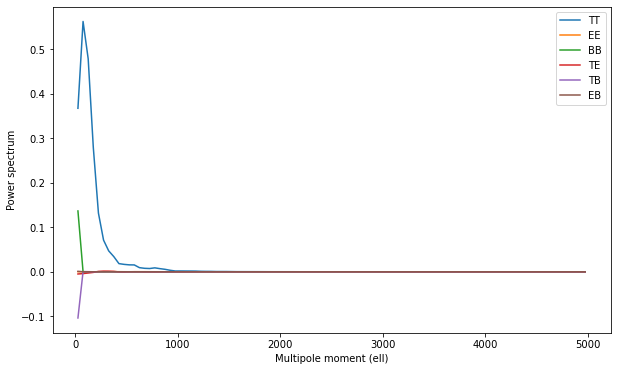

In [182]:
#Simply use the output maps by the kendrick_method_TQU_to_fourier_TEB function to build your power spectrums 
#(for which you can use the function we wrote in NB4). Keep in mind, however, the maps are outputted
#in Fourier space, so some adjustments may be need to be done.
# Convert Fourier space maps to real space
Tmap = np.real(np.fft.ifft2(np.fft.fftshift(fTmap)))
Emap = np.real(np.fft.ifft2(np.fft.fftshift(fEmap)))
Bmap = np.real(np.fft.ifft2(np.fft.fftshift(fBmap)))

# Calculate power spectra
ell, power_TT = calculate_2d_spectrum(Tmap,delta_ell,ell_max,pix_size,N,Map2=np.real(np.fft.ifft2(np.fft.fftshift(fTmap))))
ell, power_EE = calculate_2d_spectrum(Emap,delta_ell,ell_max,pix_size,N,Map2=np.real(np.fft.ifft2(np.fft.fftshift(fEmap))))
ell, power_BB = calculate_2d_spectrum(Bmap,delta_ell,ell_max,pix_size,N,np.real(np.fft.ifft2(np.fft.fftshift(fBmap))))
ell, power_TE = calculate_2d_spectrum(Tmap,delta_ell,ell_max,pix_size,N,np.real(np.fft.ifft2(np.fft.fftshift(fEmap))))
ell, power_TB = calculate_2d_spectrum(Tmap,delta_ell,ell_max,pix_size,N,np.real(np.fft.ifft2(np.fft.fftshift(fBmap))))
ell, power_EB = calculate_2d_spectrum(Emap,delta_ell,ell_max,pix_size,N,np.real(np.fft.ifft2(np.fft.fftshift(fBmap))))

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ell, power_TT, label='TT')
plt.plot(ell, power_EE, label='EE')
plt.plot(ell, power_BB, label='BB')
plt.plot(ell, power_TE, label='TE')
plt.plot(ell, power_TB, label='TB')
plt.plot(ell, power_EB, label='EB')
plt.xlabel('Multipole moment (ell)')
plt.ylabel('Power spectrum')
plt.legend()
plt.show()


your comments go here.

## Note on E-B leakage correction

The no-leak B-mode estimator in the above cells removes spurious B-modes at the level of the map. This is useful when the B-mode contribution has to be measured accurately from a small patch of the sky. In cases where some E-to-B leakage can be tolerated, the leakage can also be corrected for at the level of the power spectrum. If you want to learn more about this method you can work through [notebook 8](https://nbviewer.jupyter.org/github/ACTCollaboration/DR4_DR5_Notebooks/blob/bbc7767607c0e51a0a909ffdec617ce6c64d8388/Notebooks/Section_8_power_spectra_part_2.ipynb) of the DR4_DR5_Notebooks.

<font color='red'>ADVANCED EXCERCISE: </font> Take the `lens_map` function from the lensing notebook (part 10) and lens the Q and U maps of a polarization field that has no B-mode contribution. Plot the resulting B-mode power spectrum and compare to the CAMB B-mode power spectrum.